In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/face-expression-recognition-dataset/images/images/'):
    print(dirname)
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-expression-recognition-dataset/images/images/
/kaggle/input/face-expression-recognition-dataset/images/images/train
/kaggle/input/face-expression-recognition-dataset/images/images/train/fear
/kaggle/input/face-expression-recognition-dataset/images/images/train/surprise
/kaggle/input/face-expression-recognition-dataset/images/images/train/neutral
/kaggle/input/face-expression-recognition-dataset/images/images/train/happy
/kaggle/input/face-expression-recognition-dataset/images/images/train/angry
/kaggle/input/face-expression-recognition-dataset/images/images/train/disgust
/kaggle/input/face-expression-recognition-dataset/images/images/train/sad
/kaggle/input/face-expression-recognition-dataset/images/images/validation
/kaggle/input/face-expression-recognition-dataset/images/images/validation/fear
/kaggle/input/face-expression-recognition-dataset/images/images/validation/surprise
/kaggle/input/face-expression-recognition-dataset/images/images/validation/neutral
/kaggle

Changing the path to the dataset location

In [13]:
cd '/kaggle/input/face-expression-recognition-dataset/images/images/'

/kaggle/input/face-expression-recognition-dataset/images/images


**Import Libraries**

In [3]:
pip install livelossplot==0.5.2

     |████████████████████████████████| 496 kB 912 kB/s eta 0:00:01
  Created wheel for tornado: filename=tornado-6.0.4-cp37-cp37m-linux_x86_64.whl size=428616 sha256=4d446fab37ef1a907fb2996ad872855a6ba5a4c3c1fc262184f9544e4b0ddfd8
  Stored in directory: /root/.cache/pip/wheels/7d/14/fa/d88fb5da77d813ea0ffca38a2ab2a052874e9e1142bad0b348
Successfully built tornado
ERROR: jupyterlab-git 0.10.0 has requirement nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow.keras as keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


Checking the number of images (Imbalanced Classes)

In [5]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

4103 fear images
3205 surprise images
4982 neutral images
7164 happy images
3993 angry images
436 disgust images
4938 sad images


Plotting a sample of the images from each category

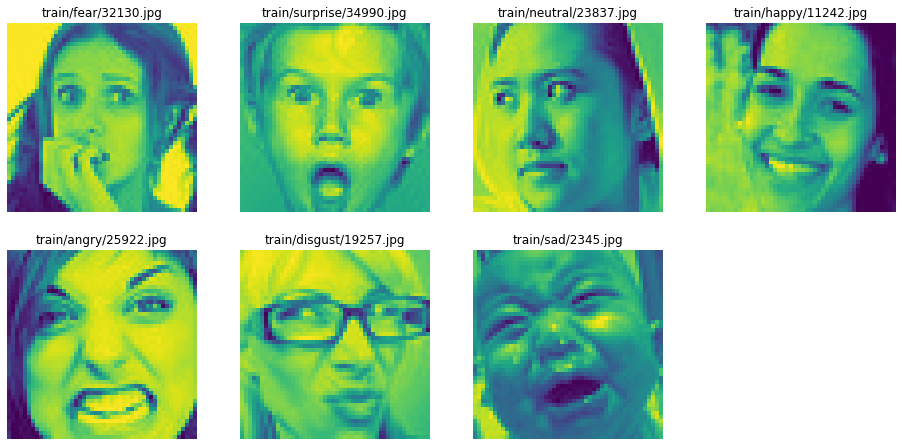

In [19]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
nrows = 4
ncols = 4

pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_pix = [os.path.join("train/" + expression+'/'+ os.listdir("train/" + expression)[0]) for expression in os.listdir("train/")]

for i, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(img_path)

plt.show()

Creating train and validation image generators for generating images with data augmentation while training the model, in memory.

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
#ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data
#Translations, Rotations, Changes in scale, Shearing, Horizontal (and in some cases, vertical) flips

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("validation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Defining the model architecture. With Convolution layers, setting activation function for the layer, batch normalization and drop out regularization against overfitting. Max Pooling Layers too.

In [7]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

Training the model

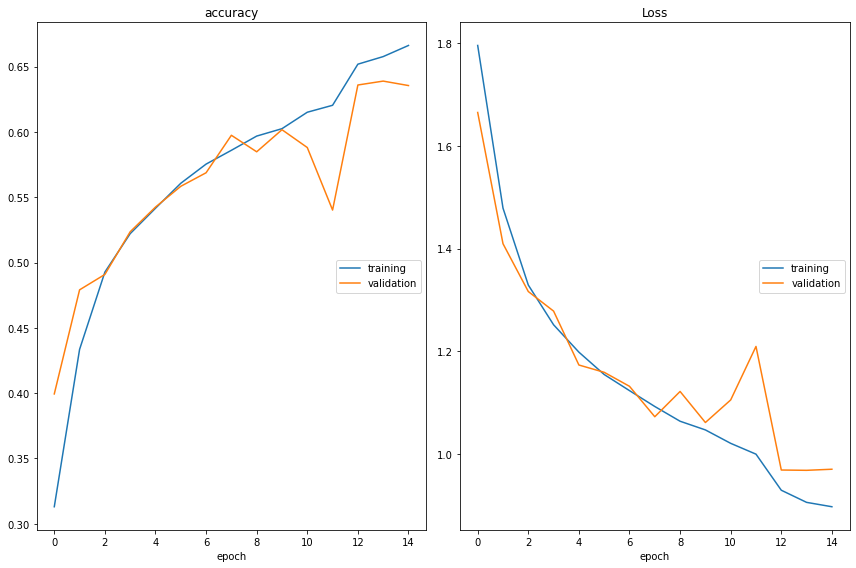

accuracy
	training         	 (min:    0.313, max:    0.666, cur:    0.666)
	validation       	 (min:    0.399, max:    0.639, cur:    0.636)
Loss
	training         	 (min:    0.897, max:    1.796, cur:    0.897)
	validation       	 (min:    0.968, max:    1.665, cur:    0.970)

Epoch 00015: saving model to model_weights.h5
450/450 [==============================] - 22s 49ms/step - loss: 0.8969 - accuracy: 0.6662 - val_loss: 0.9700 - val_accuracy: 0.6355 - lr: 5.0000e-05
CPU times: user 4min 14s, sys: 54.6 s, total: 5min 9s
Wall time: 6min 41s


In [8]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [9]:
cd /kaggle/working/

/kaggle/working


In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

**Trying Transfer Learning**  
* VGG

make your model work with grayscale images. You just need to make the image to appear to be RGB. 

In [52]:
img_size = 224
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
#ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data
#Translations, Rotations, Changes in scale, Shearing, Horizontal (and in some cases, vertical) flips

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("validation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [53]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = [224, 224]
# add preprocessing layer to the fromt of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #pooling='max')

VGG-19 is a convolutional neural network which is 19 layers deep. It's pretrained version of the network has trained on more than a million images from the ImageNet database. This network is trained on images with an input size of 224-by-224. By adding few more layers to this pretrained model, we can use it for classification of the various dance forms. As, pretrained model has already extracted out the edges and important features from millions of images, so it can classify images with much higher accuracy.

In [54]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [55]:
# added layers 
x = Flatten()(vgg.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
prediction = Dense(7, activation='softmax')(x)

In [56]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [57]:
#Compiling the model adding loss function and optimizer and evaluation metrics
model.compile( loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [58]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Set a Learning Rate Annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)


In [59]:
history = model.fit_generator(train_generator,
        validation_data = validation_generator,
        epochs = 15,
        steps_per_epoch = len(train_generator),
        validation_steps = len(validation_generator)#,
        #callbacks = [learning_rate_reduction]
)

Epoch 1/15
451/451 [==============================] - 91s 201ms/step - loss: 3.1372 - accuracy: 0.3143 - val_loss: 1.4467 - val_accuracy: 0.4413
Epoch 2/15
451/451 [==============================] - 90s 199ms/step - loss: 1.4506 - accuracy: 0.4380 - val_loss: 1.3115 - val_accuracy: 0.5041
Epoch 3/15
451/451 [==============================] - 89s 198ms/step - loss: 1.3476 - accuracy: 0.4842 - val_loss: 1.3294 - val_accuracy: 0.4983
Epoch 4/15
451/451 [==============================] - 90s 199ms/step - loss: 1.2522 - accuracy: 0.5231 - val_loss: 1.2659 - val_accuracy: 0.5224
Epoch 5/15
451/451 [==============================] - 89s 198ms/step - loss: 1.1888 - accuracy: 0.5490 - val_loss: 1.2483 - val_accuracy: 0.5297
Epoch 6/15
451/451 [==============================] - 97s 215ms/step - loss: 1.1408 - accuracy: 0.5717 - val_loss: 1.2376 - val_accuracy: 0.5328
Epoch 7/15
451/451 [==============================] - 99s 219ms/step - loss: 1.0860 - accuracy: 0.5921 - val_loss: 1.2552 - val_ac

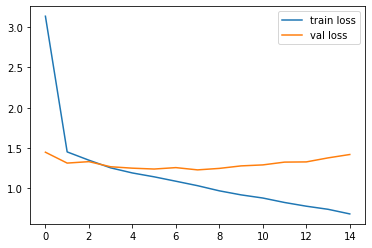

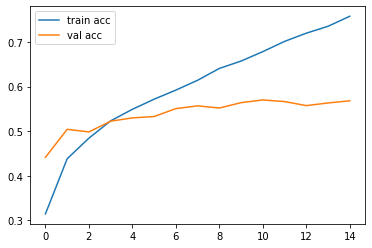

In [60]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

The accuracy didn't improve. The gap between training and validation accuracy seems to be increasing in every epoch, probably overfitting...

In [61]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

In [90]:
cd '/kaggle/input/densenet-keras'


/kaggle/input/densenet-keras


In [91]:
ls

DenseNet-BC-121-32-no-top.h5  DenseNet-BC-161-48.h5
DenseNet-BC-121-32.h5         DenseNet-BC-169-32-no-top.h5
DenseNet-BC-161-48-no-top.h5  DenseNet-BC-169-32.h5


In [92]:
# create the base pre-trained model
base_model = DenseNet121(weights='DenseNet-BC-121-32-no-top.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(7, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

#model.load_weights("./nih/pretrained_model.h5")

In [101]:
cd '/kaggle/input/face-expression-recognition-dataset/images/'

/kaggle/input/face-expression-recognition-dataset/images


In [ ]:
history = model.fit_generator(train_generator, 
                               validation_data=validation_generator,
                               steps_per_epoch = len(train_generator),
                               validation_steps = len(validation_generator), 
                               epochs = 15)
 
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()